In [1]:
# %matplotlib qt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
import math

In [2]:
def txt_to_df(data_files):
    dfs = {}
    for filename in data_files:
        freq = filename.split('_')[1].split('Hz')[0]
        print(f"Reading {freq}, {filename}...")
        with open(filename, 'r') as file:
            content = file.read()
            content = content.replace('"', '')
        
        with open(filename, 'w') as file:
            file.write(content)

        df = pd.read_csv(filename, delimiter=',')
    
        # print("Number of NaNs in each column:")
        # print(df.isnull().sum())
        df = df.dropna()
        
        df['Error'] = df[' Error']
        df['Target angle'] = df[' Target angle']
        df.drop(columns=[' Error', ' Target angle'], inplace=True)

        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col], errors='raise')
            except ValueError as e:
                print(f"\nOh Oh! Conversion failed in column: {col}, Error: {e}\n")
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # print("Number of NaNs in each column:")
        # print(df.isnull().sum())
        df = df.dropna()
        
        dfs[freq] = df

    return dfs

In [3]:

def sine_wave(t, A, phase, offset, freq):
    return A * np.sin(2 * np.pi * freq * t + phase) + offset

def get_gain_phase(data, freq, ax_target, ax_error):
    time_ms = data['Run time']
    time_ms = pd.to_numeric(time_ms, errors='raise')
    time_s = time_ms / 1000

    error = data['Error']
    target_angle = data['Target angle']
    
     # Fit sine wave to target_angle
    params_target, _ = curve_fit(
        lambda t, A, phase, offset: sine_wave(t, A, phase, offset, freq), time_s, target_angle, p0=[5, 0, 0]
        )
    A_target, phase_target, offset_target = params_target
    target_fit = sine_wave(time_s, A_target, phase_target, offset_target, freq)

    # Fit sine wave to error
    params_error, _ = curve_fit(
        lambda t, A, phase, offset: sine_wave(t, A, phase, offset, freq), time_s, error, p0=[5, 0, 0]
        )
    A_error, phase_error, offset_error = params_error
    error_fit = sine_wave(time_s, A_error, phase_error, offset_error, freq)

    # fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax_target.plot(time_s, target_angle, label='Target Angle')
    ax_target.plot(time_s, target_fit, label='Target Fit')
    ax_target.set_xlabel('Time (s)', fontsize=6)
    ax_target.set_ylabel('Angle (degrees)', fontsize=6)
    ax_target.set_title(f"Target Angle at {freq}Hz", fontsize=6)
    ax_target.tick_params(axis="both", labelsize=6)
    # ax_target.legend(fontsize=6, loc='lower right')

    ax_error.plot(time_s, error, label='Error')
    ax_error.plot(time_s, error_fit, label='Error Fit')
    ax_error.set_xlabel('Time (s)', fontsize=6)
    ax_error.set_ylabel('Angle (degrees)', fontsize=6)
    ax_error.set_title(f"Error at {freq}Hz", fontsize=6)
    ax_error.tick_params(axis="both", labelsize=6)
    # ax_error.legend(fontsize=6, loc='lower right')
    # fig.suptitle(f"Frequency: {freq} Hz")

    print(f"Target Amplitude: {A_target}, Phase: {phase_target}")
    print(f"Error Amplitude: {A_error}, Phase: {phase_error}")

    gain = abs(A_error / A_target)
    phase_diff = (phase_error - phase_target) * (180 / np.pi)

    print(f"Gain: {gain}")
    print(f"Phase Difference (degrees): {phase_diff}")

    return gain, phase_diff





In [4]:
def bode_plot(gains, phases, freqs):
    sorted_tuples = sorted(zip(freqs, gains, phases))
    freqs, gains, phases = zip(*sorted_tuples)
    print(f"Freqs: {freqs}")
    print(f"Gains: {gains}")
    print(f"Phases: {phases}")
    gain_db = 20 * np.log10(gains)
    print(gain_db)
    plt.figure()

    # Magnitude plot
    plt.subplot(2, 1, 1)
    plt.semilogx(freqs, gain_db, 'x-')
    plt.title("Bode Plot")
    plt.ylabel("Magnitude (dB)")

    # Phase plot
    plt.subplot(2, 1, 2)
    plt.semilogx(freqs, phases, 'x-')
    plt.ylabel("Phase (degrees)")
    plt.xlabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

Reading 0.01, data/data_0.01Hz.txt...

Oh Oh! Conversion failed in column: Target angle, Error: Unable to parse string " 3 18.23179" at position 806

Reading 0.02, data/data_0.02Hz.txt...
Reading 0.03, data/data_0.03Hz.txt...
Reading 0.05, data/data_0.05Hz.txt...

Oh Oh! Conversion failed in column: Target angle, Error: Unable to parse string " -27.5955.19339" at position 483

Reading 0.06, data/data_0.06Hz.txt...
Reading 0.07, data/data_0.07Hz.txt...
Reading 0.08, data/data_0.08Hz.txt...
Reading 0.09, data/data_0.09Hz.txt...
Reading 0.15, data/data_0.15Hz_notsmooth.txt...
Reading 0.1, data/data_0.1Hz.txt...
5.0

 0.01
Target Amplitude: -29.00485635445603, Phase: -4.735001462567601
Error Amplitude: 1.401989647671858, Phase: -0.06086712589994065
Gain: 0.04833637617572513
Phase Difference (degrees): 267.8081703682376

 0.02
Target Amplitude: -28.707250119172194, Phase: -4.803741915737783
Error Amplitude: 2.678645483684429, Phase: -0.19550297439228087
Gain: 0.09330902376802333
Phase Diffe

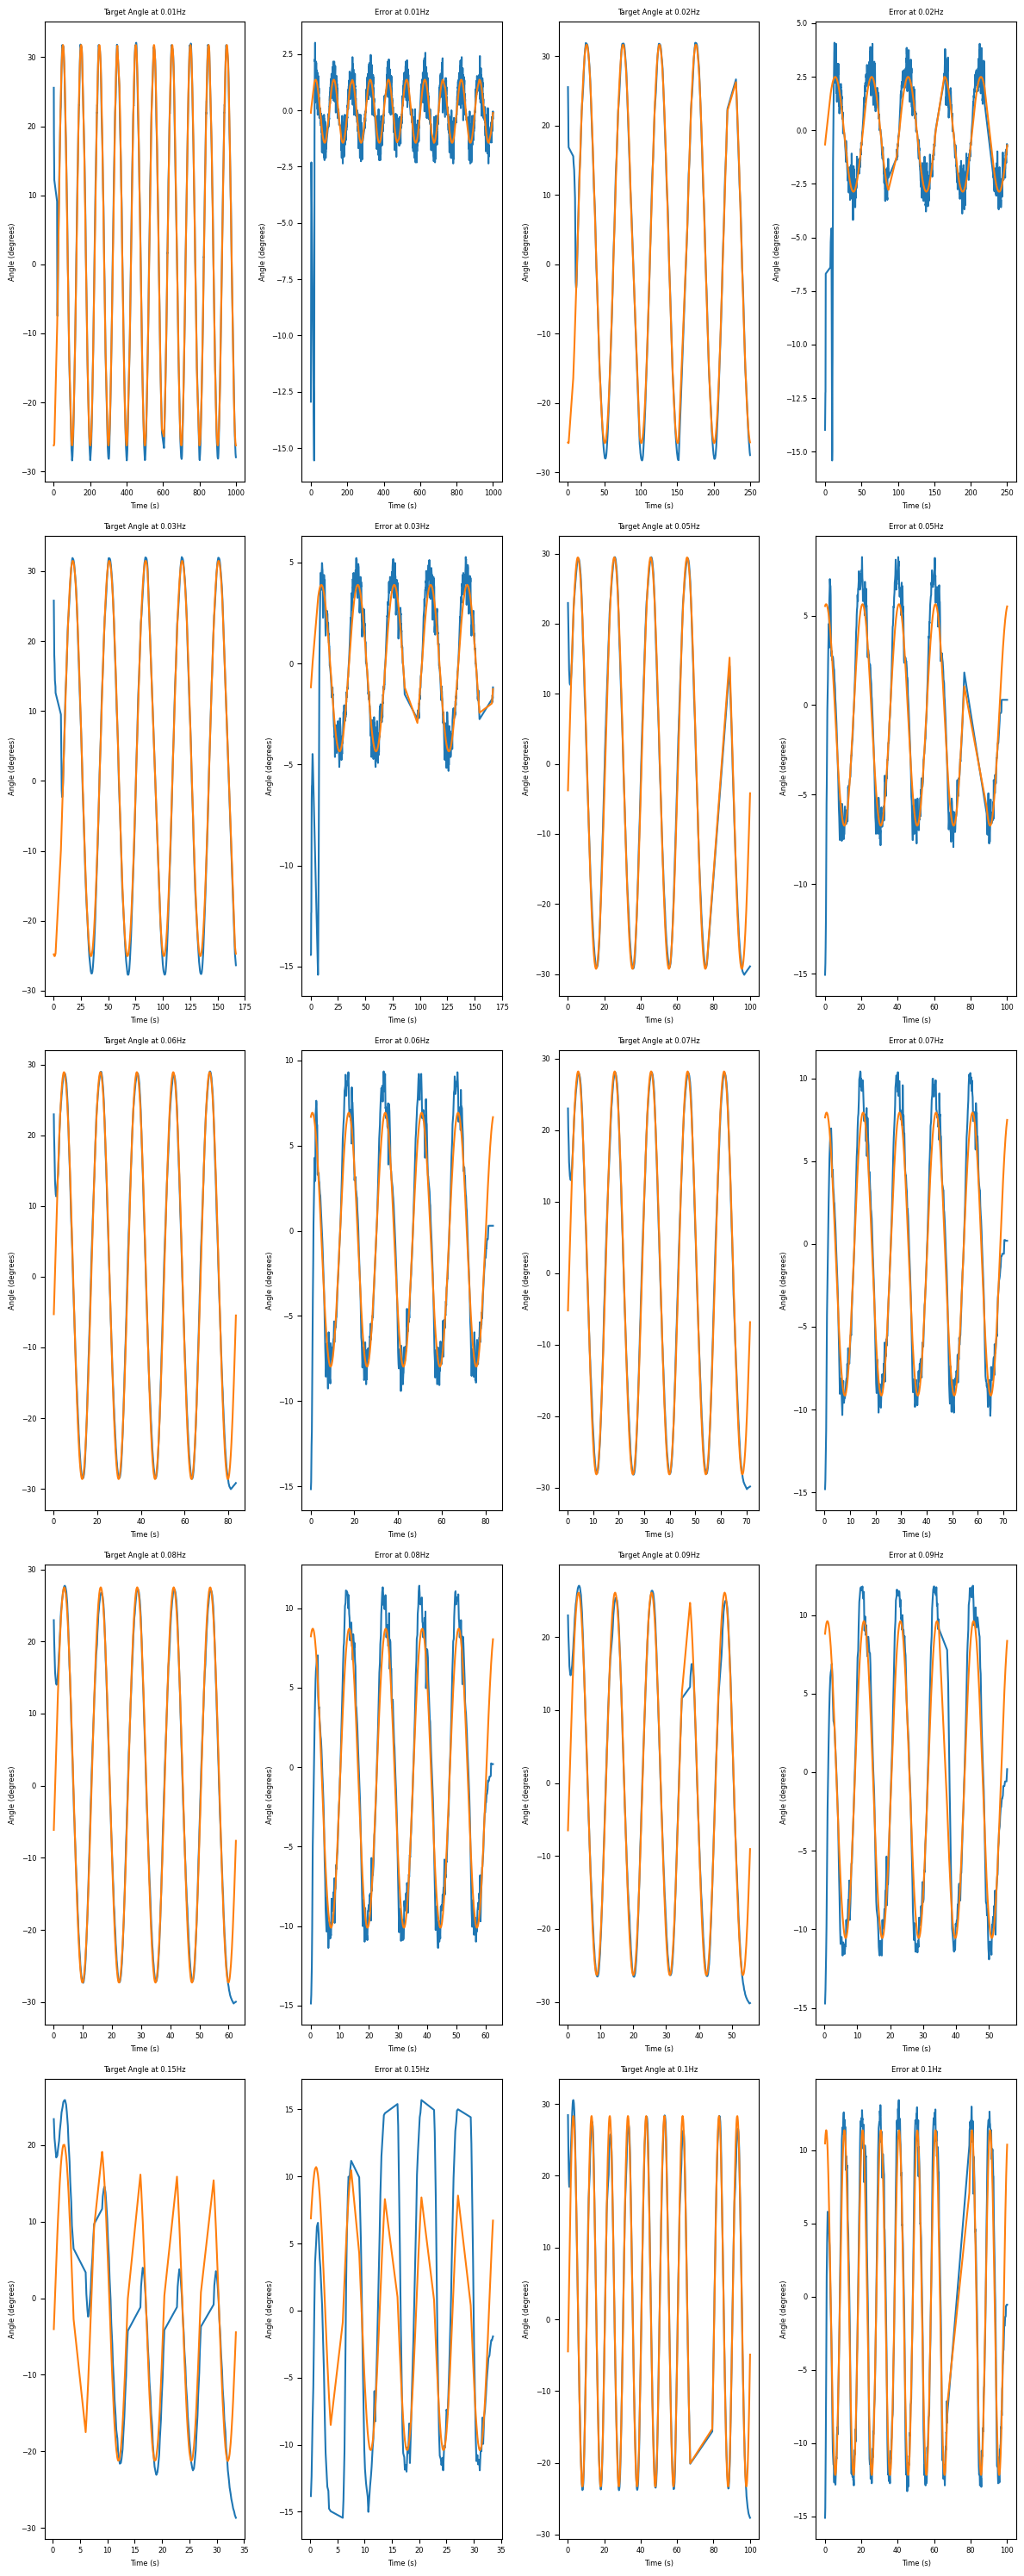

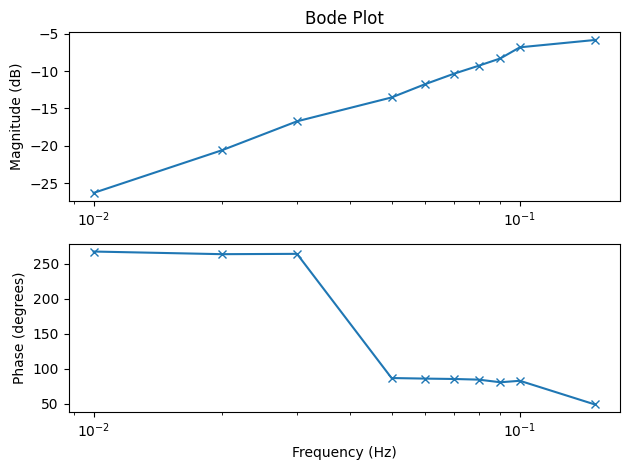

In [5]:
def run(data_files):
    plt.close('all')
    data = txt_to_df(data_files)
    gains = []
    phases = []
    freqs = []
    n_freqs = len(data_files)
    print(np.ceil(n_freqs/2))
    fig, axs = plt.subplots(int(np.ceil(n_freqs/2)), 4, figsize=(12, 3 * n_freqs))

    for i, (freq, df) in enumerate(data.items()):
        print('\n', float(freq))

        row = i // 2
        col = i % 2
        if i % 2 == 1:
            col += 1
        gain, phase_diff = get_gain_phase(df, float(freq), axs[row, col], axs[row, col+1])
        gains.append(gain)
        phases.append(phase_diff)
        freqs.append(float(freq))
        # break
    plt.tight_layout()

    print(gains)
    print(phases)
    bode_plot(gains, phases, freqs)

data_files = os.listdir("data")
data_files = sorted([f"data/{f}" for f in data_files])
# print(sorted(data_files))
run(data_files)